# Import the Dataset

In this notebook a 3D analysis of the -- is demonstated. In addition to the usuall model parameters so called 'nuisance parameters' are fitted which account for any systematical uncertainties. These sysetmatical uncertainties are assumed to be due a missmodelling of the hardronic background. 

The nuisance parameters are correlated so they can only eliminate the systemtic uncertainties but not the uncorrelated statistical uncertainicies.  

Here the Fluxpoints of the source are fitted. Hereby, the MapDatasetNuisance is sliced into certain energybins and within this energybin only the source normalisation and the nusiance parameters of this energybin are fitted. The normalisation of the bg and all the other model parameters are frozen. 

The dataset itself was set-up and fitted in the whole energyrange in the notebook `Tutorial_Nuisance_Parameter_Fitting`.


In [1]:
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import yaml
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion

import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit

In [2]:
source = 'Crab' #Crab 'GC'

In [3]:
dataset_standard = MapDataset.read(f'{source}/stacked.fits')

downsampling_factor = 100
# read the real sys amplitude here ... 
sysamplitude = abs(np.loadtxt(f'{source}/sysamplitude.txt'))/100 # this is because the sys is now in units of % of bkg

with open(f'{source}/standard_model.yml', 'r') as file:
    standard_model = yaml.full_load(file)
models = Models.from_dict(standard_model)
# gets somehow read into as an int which causes problems when printing with precison
models.parameters['reference'].error = float(models.parameters['reference'].error)

with open(f'{source}/standard_bgmodel.yml', 'r') as file:
    standard_bg_model = yaml.full_load(file)

bkg_model = FoVBackgroundModel(dataset_name = dataset_standard.name)

models.append(bkg_model)
dataset_standard.models =models

## Import the MapDatasetNuisance

In [6]:
import yaml
# reading the MapDatasetNuisance
outputfile = source
dataset_N = MapDatasetNuisance.read(outputfile+'/nui_dataset.fits')
with open(outputfile+'/nui_model.yml', 'r') as file:
    nui_model = yaml.full_load(file)
models = Models.from_dict(nui_model)
# gets somehow read into as an int which causes problems when printing with precison
models.parameters['reference'].error = float(models.parameters['reference'].error)

print(models)

with open(outputfile+'/nui_bgmodel.yml', 'r') as file:
    nui_bg_model = yaml.full_load(file)

bkg_model = FoVBackgroundModel(dataset_name = dataset_N.name, )

models.append(bkg_model)
dataset_N.models =models
dataset_N.background_model.parameters['tilt'].value = nui_bg_model['spectral']['parameters'][1]['value']
dataset_N.background_model.parameters['norm'].value = nui_bg_model['spectral']['parameters'][0]['value']
dataset_N.background_model.parameters['tilt'].frozen = False
dataset_N.background_model.parameters['tilt'].error = nui_bg_model['spectral']['parameters'][1]['error']
dataset_N.background_model.parameters['norm'].error = nui_bg_model['spectral']['parameters'][0]['error']
dataset_N.background_model.parameters['reference'].error = float(0.0)

with open(outputfile+'/nui_par.yml', ) as file:
    nui_par = yaml.full_load(file)
N_parameters = Parameters.from_dict(nui_par)
dataset_N.N_parameters =N_parameters
print("max nui par:", N_parameters.value.max())
print(dataset_N)

Models

Component 0: SkyModel

  Name                      : NGC253
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.564   +/-    0.02             
    amplitude               :   1.50e-13   +/- 2.7e-15 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0                   :     11.891   +/-    0.19 deg         
    lat_0                   :    -25.306   +/-    0.17 deg         

Component 1: FoVBackgroundModel

  Name                      : a9CLKX8Y-bkg
  Datasets names            : ['a9CLKX8Y']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :      0.968   +/-    0.02             
    tilt         (frozen)   :     -0.023                   
    reference    (frozen)   :      1.000       TeV         


max nui par: 0.12237805311985216
MapD

## Comparison to Standard Analysis

The spectral residual points show again how especially the first two energybins are not fitted well

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


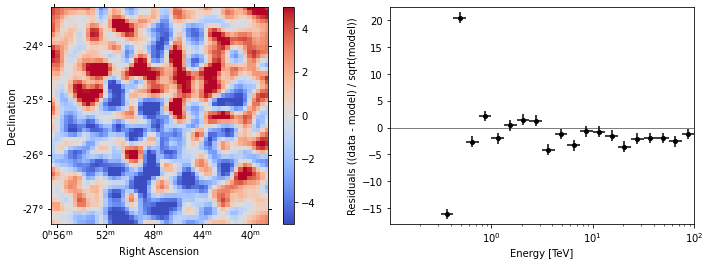

In [7]:
kwargs_spectral = dict()
kwargs_spectral["region"] = CircleSkyRegion(
    dataset_standard.geoms["geom"].center_skydir, radius=3 * u.deg
)
kwargs_spectral["method"] = "diff/sqrt(model)"
dataset_standard.plot_residuals(kwargs_spectral=kwargs_spectral);

After including the nuisance parameters the model description is much better in the first two energy bins. This indicates that the method worked and has improved out analysis.

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


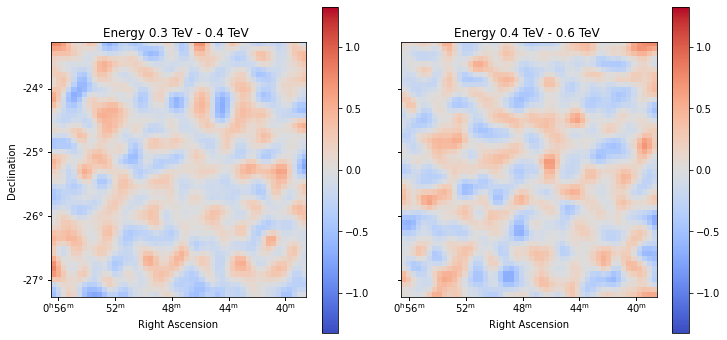

In [8]:
res_N = (
    dataset_N.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(4, 6)))
    .smooth(0.1 * u.deg)
)
vmax = np.max(np.abs(res_standard.data))
res_N.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


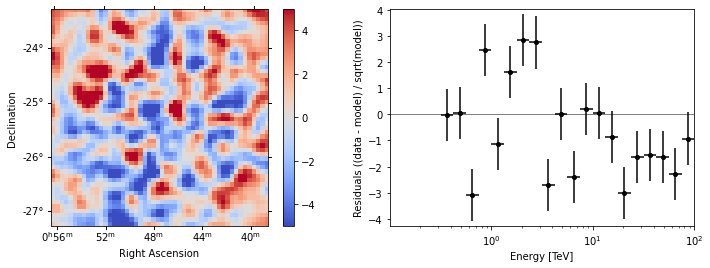

In [9]:
dataset_N.plot_residuals(kwargs_spectral=kwargs_spectral);

Her a comparison of the distribution of the significance maps in the first two energy bins is shown. With the nuisance parameters the mean of the distribution $\mu$ got closer to zero and the standard deviation $\sigma$ is closer to the expected $1$.

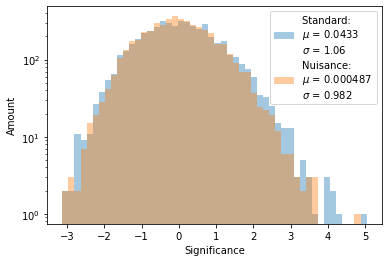

In [10]:
i_start, i_end = 4,6
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .data.flatten()
)
res_N = (
    dataset_N.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .data.flatten()
)

_, bins, _ = plt.hist(
    res_standard,
    bins=50,
    alpha=0.4,
    label="Standard: \n$\mu$ = {:.3} \n$\sigma$ = {:.3}".format(
        np.mean(res_standard), np.std(res_standard)
    ),
)
plt.hist(
    res_N,
    bins=bins,
    alpha=0.4,
    label="Nuisance: \n$\mu$ = {:.3} \n$\sigma$ = {:.3}".format(
        np.mean(res_N), np.std(res_N)
    ),
)
plt.yscale("log")
plt.legend()
plt.xlabel("Significance")
plt.ylabel("Amount");

Due to the larger parameter space, the error bars of the parameters with the nuisance parameters are larger than from the standard analysis.

In [11]:
dataset_N.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,index,2.5638e+00,,1.893e-02,nan,nan,False,
spectral,amplitude,1.4995e-13,cm-2 s-1 TeV-1,2.703e-15,nan,nan,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
spatial,lon_0,1.1891e+01,deg,1.878e-01,nan,nan,False,
spatial,lat_0,-2.5306e+01,deg,1.699e-01,-9.000e+01,9.000e+01,False,
spectral,norm,9.6845e-01,,1.903e-02,nan,nan,False,
spectral,tilt,-2.3124e-02,,2.664e-02,nan,nan,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,


In [12]:
print(" with nuisance")
print("(without nuisance)")
for p_N, p_stand in zip(dataset_N.models.parameters,dataset_standard.models.parameters ):
    print()
    print('='*50)
    print(p_N.name, p_stand.name)
    print('-'*50)
    print(' {:.3} pm {:.3}'.format(p_N.value, p_N.error) )    
    print('({:.3} pm {:.3})'.format(p_stand.value, p_stand.error) )


 with nuisance
(without nuisance)

index index
--------------------------------------------------
 2.56 pm 0.0189
(2.59 pm 0.173)

amplitude amplitude
--------------------------------------------------
 1.5e-13 pm 2.7e-15
(1.51e-13 pm 2.4e-14)

reference reference
--------------------------------------------------
 1.0 pm 0.0
(1.0 pm 0.0)

lon_0 lon_0
--------------------------------------------------
 11.9 pm 0.188
(11.9 pm 0.0113)

lat_0 lat_0
--------------------------------------------------
 -25.3 pm 0.17
(-25.3 pm 0.0106)

norm norm
--------------------------------------------------
 0.968 pm 0.019
(0.972 pm 0.00193)

tilt tilt
--------------------------------------------------
 -0.0231 pm 0.0266
(-0.0361 pm 0.00259)

reference reference
--------------------------------------------------
 1.0 pm 0.0
(1.0 pm 0.0)


## Likelihood Scan

In [13]:
fit_N = Fit(store_trace=False)
#result_N = fit_N.run([dataset_N])

In [ ]:
%%time 
parameter_standard = dataset_standard.models[0].parameters['amplitude']
parameter_N = dataset_N.models[0].parameters['amplitude']
parameter_N_frozen = dataset_N.models[0].parameters['amplitude']


parameter_standard.scan_values = np.linspace(
    parameter_standard.value-2*parameter_N.error,
    parameter_standard.value+2*parameter_N.error,
    10 )
f_standard = fit_standarad.stat_profile(
                    datasets =  [dataset_standard],
                    parameter=  parameter_standard, 
                    reoptimize = True ) 

parameter_N.scan_values = np.linspace(
    parameter_N.value-2*parameter_N.error,
    parameter_N.value+2*parameter_N.error,
    3 )
f_N = fit_N.stat_profile(
                    datasets =  [dataset_N],
                    parameter=  parameter_N, 
                    reoptimize = True ) 
parameter_N_frozen.scan_values = np.linspace(
    parameter_N.value-2*parameter_N.error,
    parameter_N.value+2*parameter_N.error,
    10 )
f_N_frozen = fit_N.stat_profile(
                    datasets =  [dataset_N],
                    parameter=  parameter_N_frozen, 
                    reoptimize = False ) 

<ValueView par_000_index=2.5895470610641205 par_001_lon_0=1.1891002622663838 par_002_lat_0=-2.530702881182409 par_003_norm=9.718320039782242 par_004_tilt=-3.6065096965928802>
<ValueView par_000_index=2.589736363768552 par_001_lon_0=1.1890966638042266 par_002_lat_0=-2.530692788854466 par_003_norm=9.718302778244558 par_004_tilt=-3.6075155103797822>
<ValueView par_000_index=2.5898617516681792 par_001_lon_0=1.1890959052440502 par_002_lat_0=-2.530681386970843 par_003_norm=9.718278886815767 par_004_tilt=-3.607935197557758>
<ValueView par_000_index=2.5899294432215307 par_001_lon_0=1.189096084766818 par_002_lat_0=-2.53066849990613 par_003_norm=9.718232299346012 par_004_tilt=-3.6081711933984253>
<ValueView par_000_index=2.589952752299143 par_001_lon_0=1.1890967217883561 par_002_lat_0=-2.530655678079174 par_003_norm=9.718174497479911 par_004_tilt=-3.6081974299565642>
<ValueView par_000_index=2.589952163586238 par_001_lon_0=1.189097448149452 par_002_lat_0=-2.530642539290284 par_003_norm=9.7181044

In [ ]:
f_standard

In [ ]:
fig = plt.figure()
ax = plt.gca()
stat_standard =  f_standard['stat_scan'] -  min(f_standard['stat_scan'])
stat_N =  f_N['stat_scan'] -  min(f_N['stat_scan'])
stat_N_frozen =  f_N_frozen['stat_scan'] -  min(f_N_frozen['stat_scan'])

plt.plot(f_standard['amplitude_scan'],stat_standard, label = "Standard Analysus", 
         color = 'orange' )
plt.plot(f_N['amplitude_scan'], stat_N, label = "With Nuisance Parameters",
        color = 'green')
plt.plot(f_N_frozen['amplitude_scan'], stat_N_frozen, label = "With Nuisance Parameters frozen",
        color = 'blue')

ylim = ax.get_ylim()
plt.vlines(parameter_standard.value, ylim[0], ylim[1],
          color = 'orange')
plt.vlines(parameter_standard.value +parameter_standard.error , ylim[0], ylim[1], 
           linestyle=':',
          color = 'orange')
plt.vlines(parameter_standard.value -parameter_standard.error , ylim[0], ylim[1], 
           linestyle=':',
          color = 'orange')

plt.vlines(parameter_N.value, ylim[0], ylim[1],
          color = 'green')
plt.vlines(parameter_N.value +parameter_N.error , ylim[0], ylim[1], 
           linestyle=':',
          color = 'green')
plt.vlines(parameter_N.value -parameter_N.error , ylim[0], ylim[1], 
           linestyle=':',
          color = 'green')

plt.vlines(parameter_N.value, ylim[0], ylim[1],
          color = 'green')
plt.vlines(parameter_N.value +parameter_N.error , ylim[0], ylim[1], 
           linestyle=':',
          color = 'green')
plt.vlines(parameter_N.value -parameter_N.error , ylim[0], ylim[1], 
           linestyle=':',
          color = 'green')

plt.legend()

## Fluxpoints of the Standard Analysis

In [ ]:
fluxpoint_bins = dataset_standard.geoms['geom'].axes[0].edges[4:7].value

In [ ]:
from gammapy.estimators import FluxPointsEstimator
from my_estimator_points_sed_19 import My_FluxPointsEstimator
from my_estimator_points_core_19 import My_FluxPoints

In [ ]:
fluxpointsestimator_standard = FluxPointsEstimator(
        energy_edges=fluxpoint_bins * u.TeV ,
        source=0,
        norm_min=0.2,
        norm_max=5,
        norm_n_values=11,
        norm_values=None,
        n_sigma=1,
        n_sigma_ul=2,
        reoptimize=False,
        selection_optional=["errn-errp", "ul","scan"],
    )

fluxpoints_standard = fluxpointsestimator_standard.run(dataset_standard)

In [ ]:
fluxpoints_standard.to_table()

In [ ]:
from gammapy.datasets import FluxPointsDataset
fluxpoints_standard.is_ul = fluxpoints_standard.ts < 4
#fluxpoints_standard.write(dataset_name_folder + 'Standard_flux_'+analysis_folder+ '.fits', overwrite= True)
flux_points_dataset_standard = FluxPointsDataset(data=fluxpoints_standard,
                                               models=dataset_standard.models[0])

In [ ]:
#ax_spectrum, ax_residuals =
flux_points_dataset_standard.plot_fit()

In [ ]:
fig  = plt.figure()
ax = plt.gca()
fluxpoints_standard.plot_ts_profiles()

## Fluxpoints of Nuisance Pseudo Dataset

In [ ]:
dataset_pseudo_N = dataset_standard.copy()
models = Models.from_dict(nui_model)
# gets somehow read into as an int which causes problems when printing with precison
models.parameters['reference'].error = float(models.parameters['reference'].error)
with open(outputfile+'/nui_bgmodel.yml', 'r') as file:
    nui_bg_model = yaml.full_load(file)
bkg_model = FoVBackgroundModel(dataset_name = dataset_pseudo_N.name, )
models.append(bkg_model)
dataset_pseudo_N.models =models
dataset_pseudo_N.background_model.parameters['tilt'].frozen = True
dataset_pseudo_N.background_model.parameters['norm'].frozen = True
dataset_pseudo_N.background = dataset_N.npred_background()


In [ ]:
fluxpointsestimator_pseudo_N = FluxPointsEstimator(
        energy_edges=fluxpoint_bins * u.TeV ,
        source=0,
        norm_min=0.2,
        norm_max=5,
        norm_n_values=11,
        norm_values=None,
        n_sigma=1,
        n_sigma_ul=2,
        reoptimize=False,
        selection_optional=["errn-errp", "ul","scan"],
    )

fluxpoints_pseudo_N = fluxpointsestimator_pseudo_N.run(dataset_pseudo_N)

In [ ]:
fluxpoints_pseudo_N.to_table()

In [ ]:
fluxpoints_pseudo_N.is_ul = fluxpoints_pseudo_N.ts < 4
#fluxpoints_standard.write(dataset_name_folder + 'Standard_flux_'+analysis_folder+ '.fits', overwrite= True)
flux_points_dataset_pseudo_N = FluxPointsDataset(data=fluxpoints_pseudo_N,
                                               models=dataset_pseudo_N.models[0])

In [ ]:
#ax_spectrum, ax_residuals =
flux_points_dataset_pseudo_N.plot_fit()


## Fluxpoints of the Dataset with Nuisance Parameters

In [ ]:
compute = 0
if compute :
    fluxpointsestimator_N_frozen = My_FluxPointsEstimator(
            energy_edges=fluxpoint_bins * u.TeV ,
            source=0,
            norm_min=0.2,
            norm_max=5,
            norm_n_values=11,
            norm_values=None,
            n_sigma=1,
            n_sigma_ul=2,
            reoptimize=False,
            selection_optional=["errn-errp","ul",  "scan"],
        )

    fluxpoints_N_frozen = fluxpointsestimator_N_frozen.run([dataset_N])
    fluxpoints_N_frozen.write(outputfile+'/nui_fluxpoints.fits',overwrite= True )
else:
    fluxpoints_N_frozen = My_FluxPoints.read(outputfile+'/nui_fluxpoints_frozen.fits')




In [ ]:
compute = 0
if compute :
    fluxpointsestimator_N = My_FluxPointsEstimator(
            energy_edges=fluxpoint_bins * u.TeV ,
            source=0,
            norm_min=0.2,
            norm_max=5,
            norm_n_values=11,
            norm_values=None,
            n_sigma=1,
            n_sigma_ul=2,
            reoptimize=True,
            selection_optional=["errn-errp","ul",  "scan"],
        )

    fluxpoints_N = fluxpointsestimator_N.run([dataset_N])
    fluxpoints_N.write(outputfile+'/nui_fluxpoints.fits',overwrite= True )
else:
    fluxpoints_N = My_FluxPoints.read(outputfile+'/nui_fluxpoints.fits')



In [ ]:
fluxpoints_N.to_table()

In [ ]:
fluxpoints_N.is_ul = fluxpoints_N.ts < 4

flux_points_dataset_N = FluxPointsDataset(data=fluxpoints_N,
                                               models=dataset_N.models[0])

In [ ]:
ax_spectrum, ax_residuals = flux_points_dataset_N.plot_fit()

In [ ]:
fig = plt.figure(figsize = (8,9))

ax_spectrum, ax_residuals = flux_points_dataset_standard.plot_fit()
'''    kwargs_spectrum={ 
                     'label':'Standard Analyis' },
    kwargs_residuals={'color':'blue',
                     'label':'Standard Analyis'});'''



flux_points_dataset_N.plot_fit(
    #kwargs_spectrum={
    #                'label':'Analyis Nuisance 2deg'},
                               ax_spectrum = ax_spectrum, ax_residuals = ax_residuals,
                    kwargs_residuals={'color':'green', 
                                      'label':'Analyis Nuisance'});
ax_spectrum.legend();
ax_residuals.legend();
ax_residuals.set_ylim(-0.2,0.2)


In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
for i in [0,1]:
    e_min, e_max = fluxpoints_standard.to_table()['e_min'][i], fluxpoints_standard.to_table()['e_max'][i]
    stat_stand = fluxpoints_standard.to_table()['stat_scan'][i] - min(fluxpoints_standard.to_table()['stat_scan'][i])
    stat_N = fluxpoints_N.to_table()['stat_scan'][i] - min(fluxpoints_N.to_table()['stat_scan'][i])
    stat_N_frozen = fluxpoints_N_frozen.to_table()['stat_scan'][i] - min(fluxpoints_N_frozen.to_table()['stat_scan'][i])


    ax[i].plot(fluxpoints_standard.to_table()['norm_scan'][i],
             stat_stand,
             label ="standard",
              color = 'orange')
    ax[i].plot(fluxpoints_N.to_table()['norm_scan'][i],
             stat_N, 'o',
             label ="nuisance", 
              color = 'green')
    
    ax[i].plot(fluxpoints_N_frozen.to_table()['norm_scan'][i],
             stat_N,
             label ="nuisance frozen", 
              color = 'blue')
    
        
    ax[i].vlines(fluxpoints_N.to_table()['norm'][i], ylim[0],ylim[1],  color = 'green')
    '''ax[i].vlines(fluxpoints_N.to_table()['norm'][i]+fluxpoints_N.to_table()['norm_err'][i],
                 ylim[0],ylim[1],linestyle=':', color = 'green',)
    ax[i].vlines(fluxpoints_N.to_table()['norm'][i]-fluxpoints_N.to_table()['norm_errn'][i],
                 ylim[0],ylim[1],linestyle=':', color = 'green',)'''
    ax[i].vlines(fluxpoints_N.to_table()['norm_ul'][i],
                 ylim[0],ylim[1],linestyle='--', color = 'green',)
    ax[i].fill_betweenx(ylim,
                        fluxpoints_N.to_table()['norm'][i]-fluxpoints_N.to_table()['norm_errn'][i], 
                        fluxpoints_N.to_table()['norm'][i]+fluxpoints_N.to_table()['norm_err'][i],
                        color = 'green' , alpha = 0.3)
    
    ax[i].vlines(fluxpoints_N_frozen.to_table()['norm'][i], ylim[0],ylim[1], color = 'blue')
    '''ax[i].vlines(fluxpoints_N.to_table()['norm'][i]+fluxpoints_N.to_table()['norm_err'][i],
                 ylim[0],ylim[1],linestyle=':', color = 'green',)
    ax[i].vlines(fluxpoints_N.to_table()['norm'][i]-fluxpoints_N.to_table()['norm_errn'][i],
                 ylim[0],ylim[1],linestyle=':', color = 'green',)'''
    ax[i].vlines(fluxpoints_N_frozen.to_table()['norm_ul'][i],
                 ylim[0],ylim[1],linestyle='--', color = 'blue',)
    ax[i].fill_betweenx(ylim,
                        fluxpoints_N_frozen.to_table()['norm'][i]-fluxpoints_N_frozen.to_table()['norm_errn'][i], 
                        fluxpoints_N_frozen.to_table()['norm'][i]+fluxpoints_N_frozen.to_table()['norm_err'][i],
                        color = 'blue' , alpha = 0.1)
    ax[i].legend(); ax[i].set_title("Energy: [{:.1}:{:.1}] TeV".format(e_min, e_max))
    ax[i].set_ylim(-5,10)

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
for i in [0,1]:
    e_min, e_max = fluxpoints_standard.to_table()['e_min'][i], fluxpoints_standard.to_table()['e_max'][i]
    stat_stand = fluxpoints_standard.to_table()['stat_scan'][i] - min(fluxpoints_standard.to_table()['stat_scan'][i])
    stat_N = fluxpoints_N.to_table()['stat_scan'][i] - min(fluxpoints_N.to_table()['stat_scan'][i])
    stat_pseudo_N = fluxpoints_pseudo_N.to_table()['stat_scan'][i] - min(fluxpoints_pseudo_N.to_table()['stat_scan'][i])


    ax[i].plot(fluxpoints_standard.to_table()['norm_scan'][i],
             stat_stand,
             label ="standard",
              color = 'orange')
    ax[i].plot(fluxpoints_N.to_table()['norm_scan'][i],
             stat_N, 'o',
             label ="nuisance", 
              color = 'green')
    
    ax[i].plot(fluxpoints_pseudo_N.to_table()['norm_scan'][i],
             stat_N,
             label ="pseudo nuisance", 
              color = 'blue')
    
    ylim = ax[i].get_ylim()
    ax[i].vlines(fluxpoints_standard.to_table()['norm'][i], ylim[0],ylim[1], color = 'orange')
    '''ax[i].vlines(fluxpoints_standard.to_table()['norm'][i]+fluxpoints_standard.to_table()['norm_errp'][i],
                 ylim[0],ylim[1],linestyle=':', color = 'orange',)
    ax[i].vlines(fluxpoints_standard.to_table()['norm'][i]-fluxpoints_standard.to_table()['norm_errn'][i],
                 ylim[0],ylim[1],linestyle=':', color = 'orange',)'''
    ax[i].vlines(fluxpoints_standard.to_table()['norm_ul'][i],
                 ylim[0],ylim[1],linestyle='--', color = 'orange',)
    xmin = fluxpoints_standard.to_table()['norm'][i]-fluxpoints_standard.to_table()['norm_errn'][i]
    if np.isnan(xmin):
        xmin = 0
    ax[i].fill_betweenx(ylim,
                        xmin, 
                        fluxpoints_standard.to_table()['norm'][i]+fluxpoints_standard.to_table()['norm_errp'][i],
                        color = 'orange' , alpha = 0.3)
    
    ax[i].vlines(fluxpoints_N.to_table()['norm'][i], ylim[0],ylim[1],  color = 'green')
    '''ax[i].vlines(fluxpoints_N.to_table()['norm'][i]+fluxpoints_N.to_table()['norm_err'][i],
                 ylim[0],ylim[1],linestyle=':', color = 'green',)
    ax[i].vlines(fluxpoints_N.to_table()['norm'][i]-fluxpoints_N.to_table()['norm_errn'][i],
                 ylim[0],ylim[1],linestyle=':', color = 'green',)'''
    ax[i].vlines(fluxpoints_N.to_table()['norm_ul'][i],
                 ylim[0],ylim[1],linestyle='--', color = 'green',)
    ax[i].fill_betweenx(ylim,
                        fluxpoints_N.to_table()['norm'][i]-fluxpoints_N.to_table()['norm_errn'][i], 
                        fluxpoints_N.to_table()['norm'][i]+fluxpoints_N.to_table()['norm_err'][i],
                        color = 'green' , alpha = 0.3)
    
    ax[i].vlines(fluxpoints_pseudo_N.to_table()['norm'][i], ylim[0],ylim[1], color = 'blue')
    '''ax[i].vlines(fluxpoints_N.to_table()['norm'][i]+fluxpoints_N.to_table()['norm_err'][i],
                 ylim[0],ylim[1],linestyle=':', color = 'green',)
    ax[i].vlines(fluxpoints_N.to_table()['norm'][i]-fluxpoints_N.to_table()['norm_errn'][i],
                 ylim[0],ylim[1],linestyle=':', color = 'green',)'''
    ax[i].vlines(fluxpoints_pseudo_N.to_table()['norm_ul'][i],
                 ylim[0],ylim[1],linestyle='--', color = 'blue',)
    ax[i].fill_betweenx(ylim,
                        fluxpoints_pseudo_N.to_table()['norm'][i]-fluxpoints_pseudo_N.to_table()['norm_errn'][i], 
                        fluxpoints_pseudo_N.to_table()['norm'][i]+fluxpoints_pseudo_N.to_table()['norm_err'][i],
                        color = 'blue' , alpha = 0.1)
    ax[i].legend(); ax[i].set_title("Energy: [{:.1}:{:.1}] TeV".format(e_min, e_max))
    ax[i].set_ylim(-5,10)

In [ ]:
sys.path.append('/home/hpc/caph/mppi045h/3D_analysis/')
import upper_limit_18_02
for i in [0,1]:
    print('='*20)
    e_min, e_max = fluxpoints_standard.to_table()['e_min'][i], fluxpoints_standard.to_table()['e_max'][i]
    print("Energy: [{:.1}:{:.1}] TeV".format(e_min, e_max))
    print()
    l_standard = dict()
    l_standard['scale_scan'] =fluxpoints_standard.to_table()['norm_scan'][i]
    stat_stand = fluxpoints_standard.to_table()['stat_scan'][i] - min(fluxpoints_standard.to_table()['stat_scan'][i])
    l_standard['stat_scan'] =stat_stand

    stat_N = fluxpoints_N.to_table()['stat_scan'][i] - min(fluxpoints_N.to_table()['stat_scan'][i])
    print('-'*20)
    print("Standard:")
    print("From Fluxpints:")
    print("norm: {:.3} pm {:.3} (UL: {:.3})".format(fluxpoints_standard.to_table()['norm'][i],
                                                   fluxpoints_standard.to_table()['norm_err'][i],
                                                   fluxpoints_standard.to_table()['norm_ul'][i]))


    ul = upper_limit_18_02.upper_limit(likelihood = l_standard, mass = 0 ,scale = 0)
    trippel = ul.likelihood_upper()
    print("From UL module:")
    print("norm: {:.3} pm {:.3} (UL: {:.3})".format(trippel[0][0],
                                                   trippel[1][0],
                                                   trippel[2]))
    l_N = dict()
    l_N['scale_scan'] =fluxpoints_standard.to_table()['norm_scan'][i]
    stat_N = fluxpoints_N.to_table()['stat_scan'][i] - min(fluxpoints_N.to_table()['stat_scan'][i])
    l_N['stat_scan'] =stat_N

    print('-'*20)
    print("Nuisance:")
    print("From Fluxpints:")
    print("norm: {:.3} pm {:.3} (UL: {:.3})".format(fluxpoints_N.to_table()['norm'][i],
                                                   fluxpoints_N.to_table()['norm_err'][i],
                                                   fluxpoints_N.to_table()['norm_ul'][i]))


    ul = upper_limit_18_02.upper_limit(likelihood = l_N, mass = 0 ,scale = 0)
    trippel = ul.likelihood_upper()
    print("From UL module:")
    print("norm: {:.3} pm {:.3} (UL: {:.3})".format(trippel[0][0],
                                                   trippel[1][0],
                                                   trippel[2]))
    
    
    l_pseudo_N = dict()
    l_pseudo_N['scale_scan'] =fluxpoints_standard.to_table()['norm_scan'][i]
    stat_pseudo_N = fluxpoints_pseudo_N.to_table()['stat_scan'][i] - min(fluxpoints_pseudo_N.to_table()['stat_scan'][i])
    l_pseudo_N['stat_scan'] =stat_pseudo_N

    print('-'*20)
    print(" Pseudo Nuisance:")
    print("From Fluxpints:")
    print("norm: {:.3} pm {:.3} (UL: {:.3})".format(fluxpoints_pseudo_N.to_table()['norm'][i],
                                                   fluxpoints_pseudo_N.to_table()['norm_err'][i],
                                                   fluxpoints_pseudo_N.to_table()['norm_ul'][i]))


    ul = upper_limit_18_02.upper_limit(likelihood = l_pseudo_N, mass = 0 ,scale = 0)
    trippel = ul.likelihood_upper()
    print("From UL module:")
    print("norm: {:.3} pm {:.3} (UL: {:.3})".format(trippel[0][0],
                                                   trippel[1][0],
                                                   trippel[2]))

    print()